<h1 align='center'>Alphabeth Handwritting Recognition</h1>
<p align='center'>Muhammad Rafly Arjasubrata</p>

<p>Pengenalan alfabet adalah salah satu tugas penting dalam pengolahan citra dan pemrosesan bahasa alami. Pengembangan model DNN dan CNN untuk pengenalan alfabet memiliki banyak aplikasi yang relevan dalam kehidupan sehari-hari.
<br><br>
Berikut pembuatan model menggunakan metode DNN dan CNN.
</p>

<p>
<br>
<b>Dataset NIST</b>
<br>
Dataset yang digunakan untuk data latih dan data validasi berasal dari <a href='https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format'>database NIST</a>.
<br><br>
Terdapat 372.450 data yang terdiri dari alfabet kapital A-Z. 5% dari data tersebut akan digunakan untuk data validasi
<br><br>
<b>Dataset NIST</b>
<br>
Untuk data uji, digunakan <a href='https://www.kaggle.com/datasets/crawford/emnist'>dataset EMNIST</a>, dimana jenis tulisan lebih bervariasi dibandingkan data NIST, ini digunakan untuk melihat seberapa baik model dalam generalisasi data.
<br><br>
Terdapat 116.322 data yang terdiri dari 0-9, A-Z, a-z. Sebanyak 31.345 data yang terdiri dari huruf kapital A-Z akan digunakan sebagai data uji.
</p>


## Import Module & Load Dataset

### Import Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

### Download Dataset

In [2]:
# Download dataset NIST
!gdown 1-5kfUzfwGZih8KD7OsKIOFP3bJx_H6_m
# Downlaod dataset EMNIST
!gdown 1el5RjKzQ70LkY-P3xjw1622x_AT_vjNv

Downloading...
From: https://drive.google.com/uc?id=1-5kfUzfwGZih8KD7OsKIOFP3bJx_H6_m
To: /content/A_Z Handwritten Data.csv
100% 699M/699M [00:05<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1el5RjKzQ70LkY-P3xjw1622x_AT_vjNv
To: /content/emnist-byclass-test.csv
100% 225M/225M [00:02<00:00, 106MB/s]


### Load Dataset & Rename Column

In [3]:
# Load Dataset NIST & Konversi ke float32
data = pd.read_csv('/content/A_Z Handwritten Data.csv').astype('float32')

# Load Dataset EMNIST & Konversi ke float32
dataTest = pd.read_csv('/content/emnist-byclass-test.csv').astype('float32')

Dataset NIST dan EMNIST masing masing memiliki resolusi 28x28. Data tersebut disimpan dalam bentuk csv

Dataset NIST memiliki 785 kolom, dimana kolom pertama merupakan label 0 - 25 yang merepresentasikan A - Z. 784 kolom lainnya berisi nilai piksel dari gambar 28x28

Dataset NIST memiliki 785 kolom, dimana kolom pertama merupakan label. Label dari alfabet kapital A-Z adalah 10 - 35. 784 kolom lainnya berisi nilai piksel dari gambar 28x28


In [4]:
# Inisialisasi Nama Kolom Baru
columnNames = ['label'] + [str(i) for i in range(784)]

# Ganti nama Kolom pada DataFrame NIST & EMNIST
data.columns = columnNames
dataTest.columns = columnNames

In [5]:
# Label pada data NIST dikurangi 10 agar label huruf kapital ada pada range 0-25
dataTest['label'] = dataTest['label'] - 10

### Contoh Gambar dari Setiap Dataset

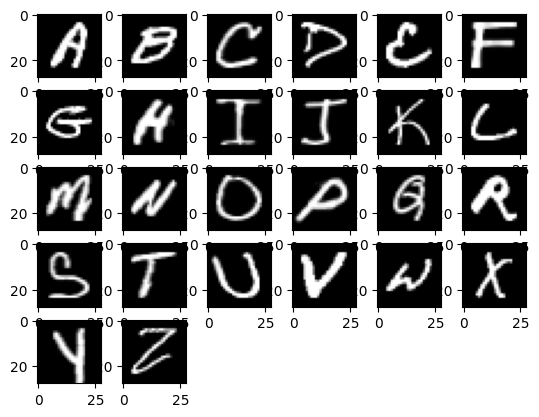

In [6]:
# Cetak contoh setiap abjad pada dataset NIST
for i in range(26) :
    # Ambil salah satu data dari label yang ditentukan
    img = data.loc[data['label'] == i].iloc[0][1:].values
    # Reshape ukuran gambar ke 28x28
    img = img.reshape(28,28)

    # Plot gambar
    im = plt.subplot(5, 6, i+1)
    im.imshow(img, cmap='gray')

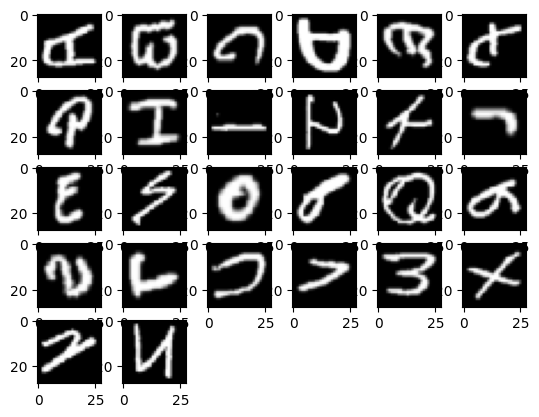

In [7]:
# Cetak contoh setiap abjad pada dataset EMNIST
for i in range(26) :
    # Ambil salah satu data dari label yang ditentukan
    img = dataTest.loc[dataTest['label'] == i].iloc[0][1:].values
    # Reshape ukuran gambar ke 28x28
    img = img.reshape(28,28)

    # Plot gambar
    im = plt.subplot(5, 6, i+1)
    im.imshow(img, cmap='gray')

Dapat dilihat dari hasil plot data EMNIST diatas, gambar harus diputar 90derajat searah jarum jam dan diflip secara vertikal.

### Frekuensi Label pada Masing-Masing Dataset

In [8]:
def convertToLetter(label):
    '''
    Function untuk mengubah label numerik menjadi alfabet
    '''

    return chr(ord('A') + int(label))

<Axes: title={'center': 'Frekuensi Label NIST'}>

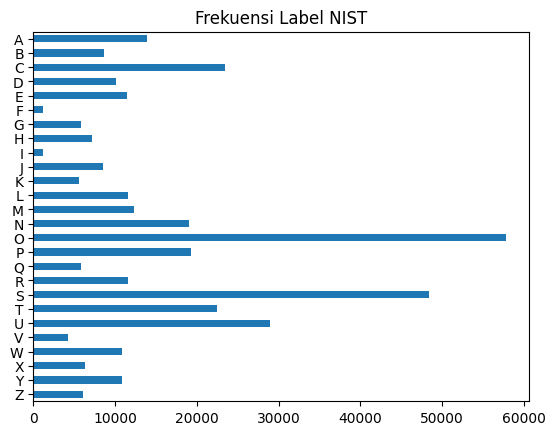

In [9]:
labelData = pd.DataFrame(data[['label']])

# Apply the conversion function to the 'label' column
labelData['letter'] = labelData['label'].apply(convertToLetter)
labelData['letter'].value_counts().sort_index(ascending=False).plot(kind='barh', title='Frekuensi Label NIST')


<Axes: title={'center': 'Frekuensi Label EMNIST'}>

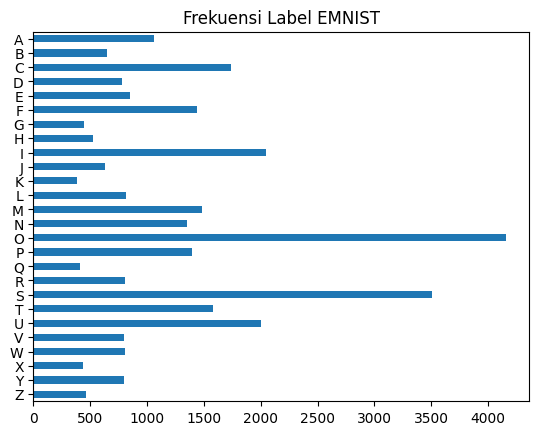

In [10]:
labelDataTest = pd.DataFrame(dataTest[dataTest['label'].isin(range(0,26))][['label']])

# Apply the conversion function to the 'label' column
labelDataTest['letter'] = labelDataTest['label'].apply(convertToLetter)
labelDataTest['letter'].value_counts().sort_index(ascending=False).plot(kind='barh', title='Frekuensi Label EMNIST')


## Pre-Processing Data

### Function untuk Crop Data Latih & Validasi

In [11]:
def cropImages(images, cropSize):
    '''
    Funtion untuk crop data NIST. Crop dilakukan dengan titik anchor ditengah
    agar tidak ada fitur (isi piksel dari gambar) yang terbuang.
    '''

    # Variabel untuk jumlah data dan kolom
    numImages, numColumns = images.shape
    # Array untuk menyimpan gambar yang sudah di crop
    croppedImages = np.empty((numImages, cropSize**2), dtype=np.uint8)

    # Urutan Baris dan Kolom untuk cropping
    startRow = (28 - cropSize) // 2
    endRow = startRow + cropSize
    startCol = (28 - cropSize) // 2
    endCol = startCol + cropSize

    # Loop untuk crop setiap gambar
    for i in range(numImages):
        # Reshape & Crop gambar
        croppedImg = images[i].reshape(28, 28)[startRow:endRow, startCol:endCol]
        # Append gambar ke array gambar yang sudah di crop
        croppedImages[i] = croppedImg.flatten()

    # Return array dari gambar yang sudah dicrop
    return croppedImages

### Function untuk Crop dan Transformasi Data Uji

In [12]:
def cropTransformImages(images, cropSize):
    '''
    Funtion untuk crop data EMNIST. Crop dilakukan dengan titik anchor ditengah
    agar tidak ada fitur (isi piksel dari gambar) yang terbuang. Dilakukan
    rotasi 90derajat searah jarum jam, kemudian dilakuakn flip secara vertikal
    pada gambar.
    '''

    # Variabel untuk jumlah data dan kolom
    numImages, numColumns = images.shape
    # Array untuk menyimpan gambar yang sudah di crop
    croppedImages = np.empty((numImages, cropSize**2), dtype=np.uint8)

    # Urutan Baris dan Kolom untuk cropping
    startRow = (28 - cropSize) // 2
    endRow = startRow + cropSize
    startCol = (28 - cropSize) // 2
    endCol = startCol + cropSize

    # Loop untuk crop setiap gambar
    for i in range(numImages):
        # Reshape & Crop gambar
        croppedImg = images[i].reshape(28, 28)[startRow:endRow, startCol:endCol]

        # Rotasi gambar 90derajat
        croppedImg = np.rot90(croppedImg, k=3)
        # Flip Gambar secara vertikal
        croppedImg = np.fliplr(croppedImg)

        # Append gambar ke array gambar yang sudah di crop
        croppedImages[i] = croppedImg.flatten()

    # Return array dari gambar yang sudah dicrop
    return croppedImages

### Crop & Transformasi Data

In [13]:
# Ukuran gambar setelah dicrop
cropSize = 20


'''Crop Data NIST'''
# Buat DataFrame baru dari gambar yang sudah dicrop
croppedImages = pd.DataFrame(cropImages(data.drop('label', axis=1).values, cropSize), columns=range(cropSize**2))
# Concat label dengan gambar yang sudah dicrop
data = pd.concat([data[['label']], croppedImages], axis=1)
# Hapus DataFrame dari gambar yang sudah dicrop
del croppedImages

'''Crop & Transformasi Data EMNIST'''
# Buat DataFrame baru dari gambar yang sudah dicrop
croppedImages = pd.DataFrame(cropTransformImages(dataTest.drop('label', axis=1).values, cropSize), columns=range(cropSize**2))
# Concat label dengan gambar yang sudah dicrop
dataTest = pd.concat([dataTest[['label']], croppedImages], axis=1)
# Hapus DataFrame dari gambar yang sudah dicrop
del croppedImages

### Contoh Gambar yang Sudah Dicrop & Transformasi

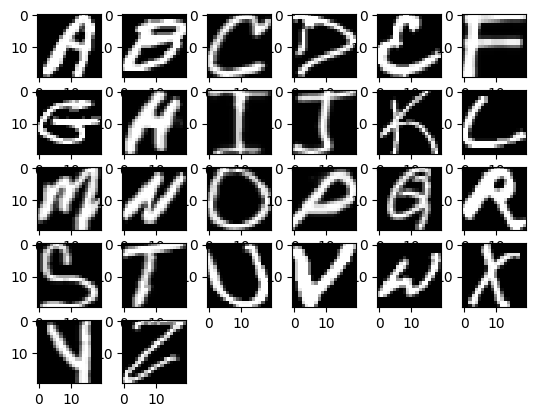

In [14]:
# Cetak contoh setiap abjad pada dataset NIST Setelah Crop
for i in range(26) :
    # Ambil salah satu data dari label yang ditentukan
    img = data.loc[data['label'] == i].iloc[0][1:].values
    # Reshape ukuran gambar sesuai ukuran crop
    img = img.reshape(cropSize,cropSize)

    # Plot gambar
    im = plt.subplot(5, 6, i+1)
    im.imshow(img, cmap='gray')

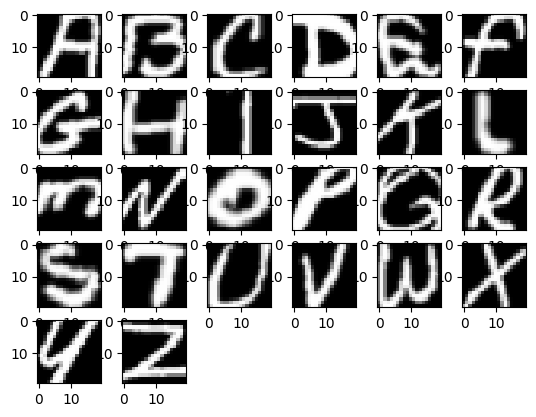

In [15]:
# Cetak contoh setiap abjad pada dataset EMNIST Setelah Crop & Transformasi
for i in range(26) :
    # Ambil salah satu data dari label yang ditentukan
    img = dataTest.loc[dataTest['label'] == i].iloc[0][1:].values
    # Reshape ukuran gambar sesuai ukuran crop
    img = img.reshape(cropSize,cropSize)

    # Plot gambar
    im = plt.subplot(5, 6, i+1)
    im.imshow(img, cmap='gray')

### Split Target & Feature dan Normalisasi Feature

In [16]:
'''Split Feature & Label Pada Data NIST'''
# Reshape & Normalisasi Feature
x = data.drop('label', axis=1).values.reshape(-1, cropSize, cropSize, 1) / 255
# One-Hot Encoding pada Label
y = pd.get_dummies(data['label'], prefix=None, dtype=int).values

'''Split Feature & Label Pada Data EMNIST'''
# Ambil Alfabet Kapital A-Z pada Data EMNIST
dataTest = dataTest[dataTest['label'].isin(range(0,26))]
# Reshape & Normalisasi Feature
xTest = dataTest.drop('label', axis=1).values.reshape(-1, cropSize, cropSize, 1) / 255
# One-Hot Encoding pada Label
yTest = pd.get_dummies(dataTest['label'], prefix=None, dtype=int).values

### Split Data Latih & Validasi

In [17]:
# Split Data Latih dan Validasi
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.05, random_state=1)

# Ukuran Data Latih, Validas, dan Test
print("Data Train & Val Shape : ", xTrain.shape, xVal.shape, yTrain.shape, yVal.shape)
print("Data Test Shape : ", xTest.shape, yTest.shape)

Data Train & Val Shape :  (353827, 20, 20, 1) (18623, 20, 20, 1) (353827, 26) (18623, 26)
Data Test Shape :  (31345, 20, 20, 1) (31345, 26)


## Deep Neural Network

### Inisialisasi Model DNN

In [18]:
DNNmodel = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Flatten(input_shape=(cropSize,cropSize,1)),

    # Hidden Layer
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output Layer
    tf.keras.layers.Dense(units=26, activation='softmax')
])

### Compile Model DNN

In [19]:
DNNmodel.compile(
    optimizer='Adamax',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Keterangan Parameter Model DNN

In [20]:
DNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 256)               102656    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 26)                6682      
                                                                 
Total params: 109338 (427.10 KB)
Trainable params: 109338 (427.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train Model DNN

In [21]:
# Start Timestamp Pelatihan Model
startTime = time.time()

In [22]:
DNNhistory = DNNmodel.fit(
    xTrain, yTrain, # Data Latih dan Label
    batch_size = 16,
    epochs=8,
    validation_data=(xVal, yVal),
    verbose=1,
)

Epoch 1/8
22115/22115 [==============================] - 87s 4ms/step - loss: 0.3719 - accuracy: 0.8990 - val_loss: 0.1851 - val_accuracy: 0.9524
Epoch 2/8
22115/22115 [==============================] - 79s 4ms/step - loss: 0.1857 - accuracy: 0.9495 - val_loss: 0.1367 - val_accuracy: 0.9648
Epoch 3/8
22115/22115 [==============================] - 78s 4ms/step - loss: 0.1493 - accuracy: 0.9591 - val_loss: 0.1169 - val_accuracy: 0.9689
Epoch 4/8
22115/22115 [==============================] - 78s 4ms/step - loss: 0.1298 - accuracy: 0.9644 - val_loss: 0.1052 - val_accuracy: 0.9719
Epoch 5/8
22115/22115 [==============================] - 81s 4ms/step - loss: 0.1169 - accuracy: 0.9680 - val_loss: 0.0965 - val_accuracy: 0.9747
Epoch 6/8
22115/22115 [==============================] - 77s 3ms/step - loss: 0.1078 - accuracy: 0.9700 - val_loss: 0.0901 - val_accuracy: 0.9767
Epoch 7/8
22115/22115 [==============================] - 76s 3ms/step - loss: 0.1001 - accuracy: 0.9720 - val_loss: 0.0852 -

In [23]:
# End Timestamp Pelatihan Model
endTime = time.time()
print("DNN Training Time")
print("--- %s seconds ---" % (endTime - startTime))

DNN Training Time
--- 635.5967757701874 seconds ---


### Evaluasi Model DNN

In [24]:
# Prediksi Data Validasi
valLoss, valAccuracy = DNNmodel.evaluate(xVal, yVal, verbose=False)
# Prediksi Data EMNIST
testLoss, testAccuracy = DNNmodel.evaluate(xTest, yTest, verbose=False)

print('Validation Data accuracy = ', valAccuracy*100)
print('EMNIST Testing accuracy = ', testAccuracy*100)

Validation Data accuracy =  97.87896871566772
EMNIST Testing accuracy =  84.33243036270142


#### Plot Akurasi per Epoch Model DNN

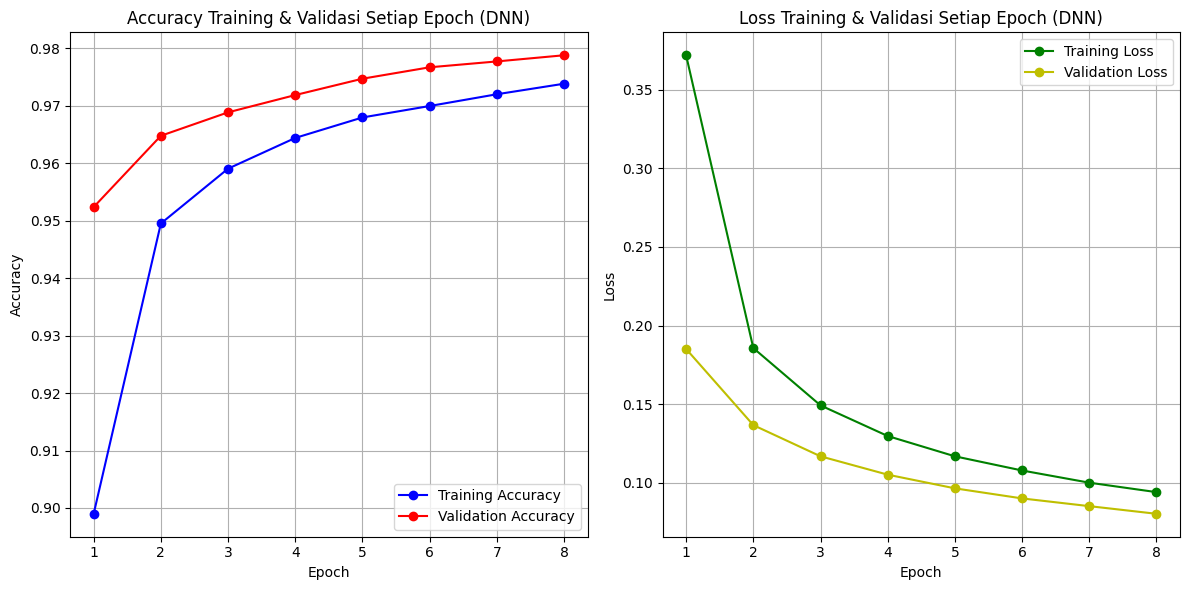

In [25]:
# Inisialisasi ukuran plot
plt.figure(figsize=(12, 6))

# Plot untuk akurasi
plt.subplot(1, 2, 1)
# Plot akurasi training
plt.plot(np.arange(1, len(DNNhistory.history['accuracy']) + 1), DNNhistory.history['accuracy'], marker='o', linestyle='-', color='b', label='Training Accuracy')
# Plot akurasi validasi
plt.plot(np.arange(1, len(DNNhistory.history['val_accuracy']) + 1), DNNhistory.history['val_accuracy'], marker='o', linestyle='-', color='r', label='Validation Accuracy')

# Keterangan Plot
plt.title('Accuracy Training & Validasi Setiap Epoch (DNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot untuk loss
plt.subplot(1, 2, 2)
# Plot loss training
plt.plot(np.arange(1, len(DNNhistory.history['loss']) + 1), DNNhistory.history['loss'], marker='o', linestyle='-', color='g', label='Training Loss')
# Plot loss validasi
plt.plot(np.arange(1, len(DNNhistory.history['val_loss']) + 1), DNNhistory.history['val_loss'], marker='o', linestyle='-', color='y', label='Validation Loss')

# Keterangan Plot
plt.title('Loss Training & Validasi Setiap Epoch (DNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Menyesuaikan Tata Letak
plt.tight_layout()

# Cetak plot
plt.show()

#### Confusion Matrix DNN

980/980 [==============================] - 2s 2ms/step
DNN Inference Time on EMNIST Dataset
--- 2.0601232051849365 seconds ---


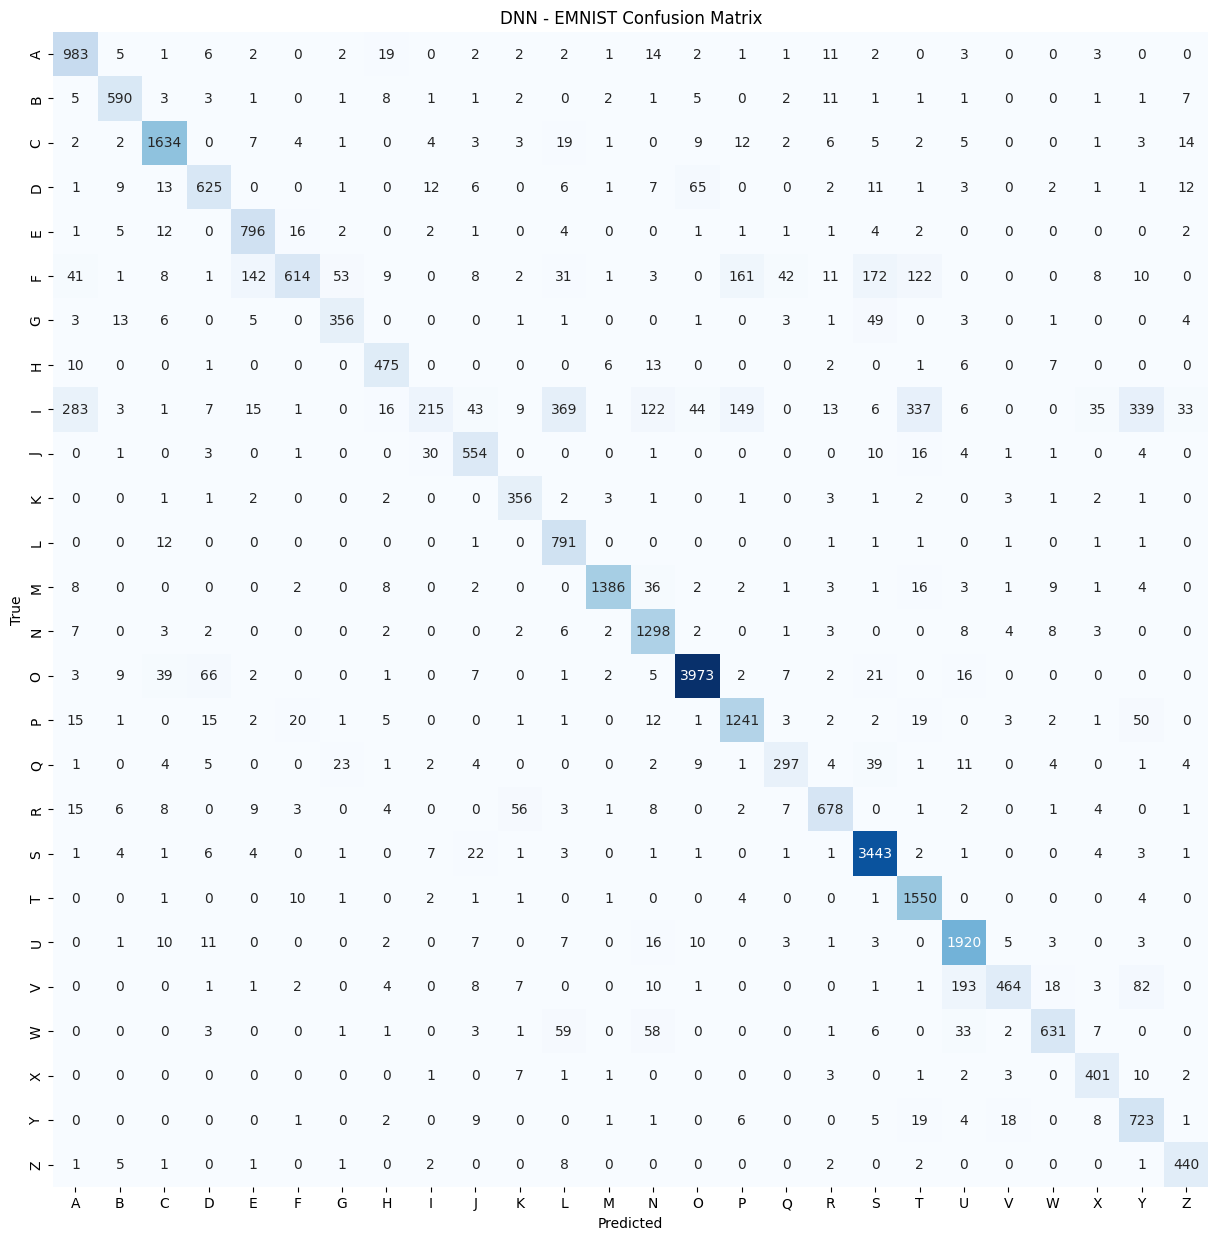

In [49]:
# Prediksi data EMNIST
startTime = time.time()
dnnEMNISTPred = np.argmax(DNNmodel.predict(xTest), axis=1)
endTime = time.time()
print("DNN Inference Time on EMNIST Dataset")
print("--- %s seconds ---" % (endTime - startTime))

# Buat confusion matrix berdasarkan hasil prediksi
cm = confusion_matrix(np.argmax(yTest, axis=1), dnnEMNISTPred)
# List label untuk confusion matrix
labelList = [chr(label+65) for label in range(26)]

# Plot confusion matrix dalam heatmap dengan letter labels
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labelList, yticklabels=labelList)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DNN - EMNIST Confusion Matrix')
plt.show()

Dapat dilihat dari confusion matrix diatas, model banyak membuat keasalahan pada label `I` dan `F`. Ini dibuktikan dengan nilai recall yang rendah.

###  Precision, Recall, F1 Score Model DNN

In [27]:
# Hitung Precision, Recall, and F1 Score menggunakan classification_report
classificationReportDNN = classification_report(np.argmax(yTest, axis=1), dnnEMNISTPred, target_names=labelList)  # Replace labelList with your class labels

#### Cari Data Dengan Metrik Evaluasi Ter-rendah

In [28]:
# Inisialisasi Dictionary untuk menyimpan data evaluasi
precisionDictDNN = {}
recallDictDNN = {}
f1ScoreDictDNN = {}

# Split data metrik evaluasi ke dalam dictionary
for line in classificationReportDNN.split('\n')[2:-5] :
    label, precision, recall, f1Score = line.split()[:4]

    precisionDictDNN[label] = float(precision)
    recallDictDNN[label] = float(recall)
    f1ScoreDictDNN[label] = float(f1Score)

# Sort nilai precision secara ascending
sortedPrecisionDNN = sorted(precisionDictDNN.items(), key=lambda item: item[1])
# Sort nilai recall secara ascending
sortedRecallDNN = sorted(recallDictDNN.items(), key=lambda item: item[1])
# Sort nilai F1 score secara ascending
sortedF1ScoreDNN = sorted(f1ScoreDictDNN.items(), key=lambda item: item[1])

# Ambil 5 skor precision ter-rendah beserta label dan nilai recallnya
lowestPrecisionDNN = sortedPrecisionDNN[:5]
lowestPrecisionLabelsDNN = [item[0] for item in sortedPrecisionDNN[:5]]
recallValuesDNN = [recallDictDNN[label] for label in lowestPrecisionLabelsDNN]

# Ambil 5 skor recall ter-rendah beserta label dan nilai precisionnya
lowestRecallDNN = sortedRecallDNN[:5]
lowestRecallLabelsDNN = [item[0] for item in sortedRecallDNN[:5]]
precisionValuesDNN = [precisionDictDNN[label] for label in lowestRecallLabelsDNN]

# Ambil 5 skor F1 score ter-rendah beserta labelnya
lowestF1ScoreDNN = sortedF1ScoreDNN[:5]
lowestF1ScoreLabelsDNN = [item[0] for item in lowestF1ScoreDNN]

#### Plot Label Dengan Precision Score Ter-rendah

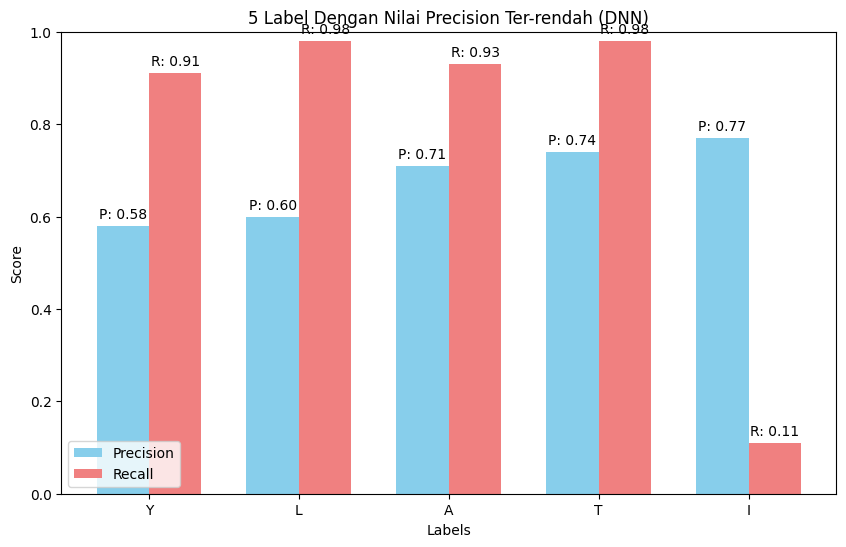

In [29]:
# Plot Jumlah, Lebar, dan Jarak antar label
x = np.arange(len(lowestPrecisionLabelsDNN))  # posisi x-axis
width = 0.35  # Lebar barchart

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot nilai precision
precisionBars = ax.bar(x - width/2, [item[1] for item in lowestPrecisionDNN], width, label='Precision', color='skyblue')
# Plot nilai recall
recallBars = ax.bar(x + width/2, recallValuesDNN, width, label='Recall', color='lightcoral')

# Loop untuk menambahkan nilai di atas setiap bar precision
for i, bar in enumerate(precisionBars):
    # Ambil nilai recall
    precisionValue = lowestPrecisionDNN[i][1]
    # Cetak nilai recall diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'P: {precisionValue:.2f}', ha='center', va='bottom')

# Loop untuk menambahkan nilai di atas setiap bar recall
for i, bar in enumerate(recallBars) :
    # Ambil nilai recall
    recallValue = recallValuesDNN[i]
    # Cetak nilai recall diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
        f'R: {recallValue:.2f}', ha='center', va='bottom')

# Tambah labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Score')
ax.set_title('5 Label Dengan Nilai Precision Ter-rendah (DNN)')
ax.set_xticks(x)
ax.set_xticklabels(lowestPrecisionLabelsDNN)
ax.set_ylim(0,1)
ax.legend(loc='lower left')

# Print barchart
plt.show()


Dari graf diatas juga menunjukkan terdapat beberapa label dengan nilai precision yang rendah, namun memiliki nilai recall yang tinggi. Ini mengindikasikan bahwa model cenderung mengidentifikasi beberapa label seperti `Y` dan `L` cenderung mampu mengidentifikasi sebagian besar karakter tersebut yang sebenarnya ada dalam data. Ini mengindikasikan  bahwa model memiliki kemampuan baik memprediksi huruf tersebut.

#### Plot Label Dengan Recall Ter-rendah

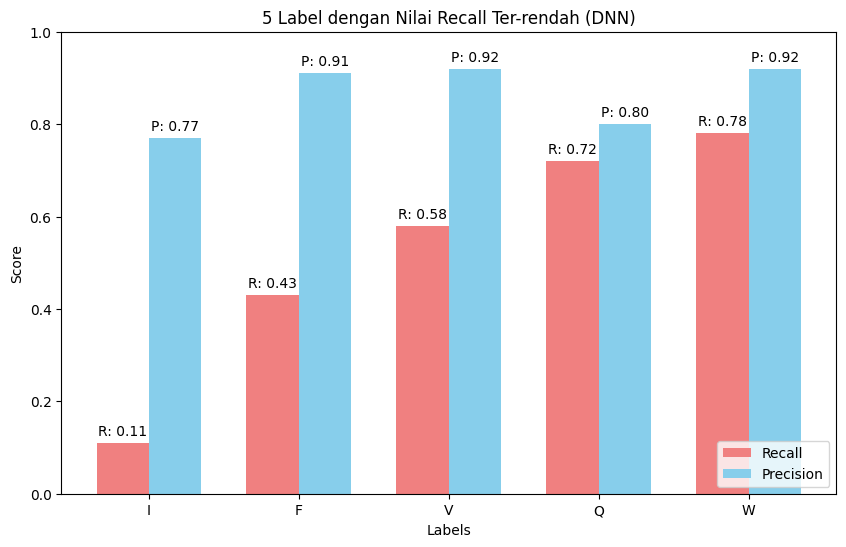

In [30]:
# Plot Jumlah, Lebar, dan Jarak antar label
x = np.arange(len(lowestRecallLabelsDNN))  # posisi x-axis
width = 0.35  # Lebar barchart

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot nilai recall
recallBars = ax.bar(x - width/2, [item[1] for item in lowestRecallDNN], width, label='Recall', color='lightcoral')
# Plot nilai precision
precisionBars = ax.bar(x + width/2, precisionValuesDNN, width, label='Precision', color='skyblue')

# Loop untuk menambahkan nilai di atas setiap bar recall
for i, bar in enumerate(recallBars):
    # Ambil nilai recall
    recallValue = lowestRecallDNN[i][1]
    # Cetak nilai recall diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'R: {recallValue:.2f}', ha='center', va='bottom')

# Loop untuk menambahkan nilai di atas setiap bar precision
for i, bar in enumerate(precisionBars) :
    # Ambil nilai precision
    precisionValue = precisionValuesDNN[i]
    # Cetak nilai precision diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
        f'P: {precisionValue:.2f}', ha='center', va='bottom')

# Tambah labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Score')
ax.set_title('5 Label dengan Nilai Recall Ter-rendah (DNN)')
ax.set_xticks(x)
ax.set_xticklabels(lowestRecallLabelsDNN)
ax.set_ylim(0,1)
ax.legend(loc='lower right')

# Print barchart
plt.show()

Nilai recall yang rendah mengindikasikan bahwa model cenderung tidak mengenali sebagian besar karakter `I` yang sebenarnya. Ini dapat mengakibatkan kinerja yang kurang baik dalam situasi dimana mengindentifikasi semua karakter `I` sebenarnya sangat penting.

Namun nilai precision yang tinggi mengindikasikan semua karakter yang diprediksi sebagai `I`, sebagian besar memang karakter `I` yang sebenarnya. Tren ini juga terjadi pada beberapa label seperti `F` dan `V`.

#### Plot label dengan F1 Score ter-rendah

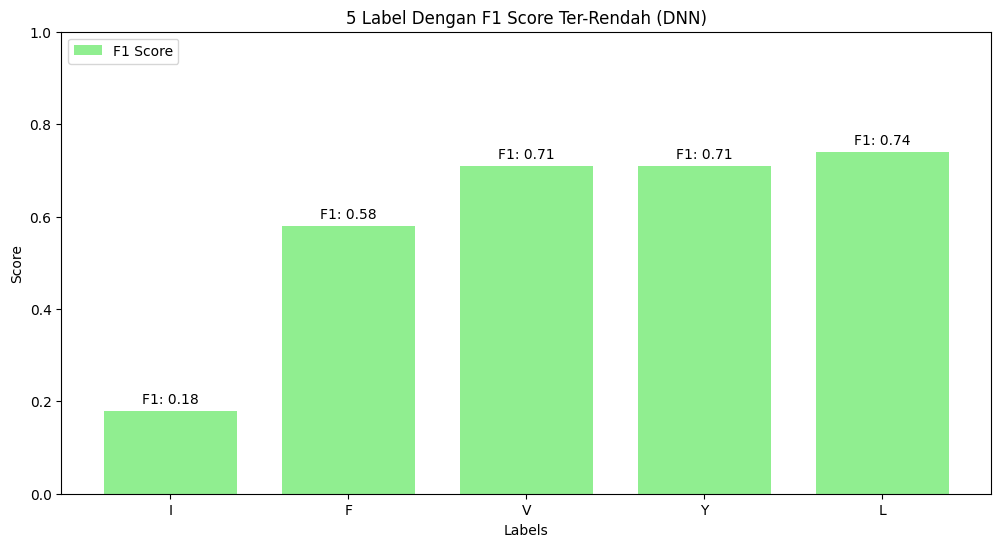

In [31]:
# Plot Jumlah, Lebar, dan Jarak antar label
x = np.arange(len(lowestF1ScoreLabelsDNN))  # posisi x-axis
width = 0.75  # Lebar barchart

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(12, 6))
# Plot nilai F1 Score
f1ScoreBars = ax.bar(x, [item[1] for item in lowestF1ScoreDNN], width, label='F1 Score', color='lightgreen')

# Loop untuk menambahkan nilai di atas setiap bar f1Score
for i, bar in enumerate(f1ScoreBars):
    # Ambil nilai f1Score
    f1Value = lowestF1ScoreDNN[i][1]
    # Cetak nilai f1Score diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'F1: {f1Value:.2f}', ha='center', va='bottom')

# Tambah labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Score')
ax.set_title('5 Label Dengan F1 Score Ter-Rendah (DNN)')
ax.set_xticks(x)
ax.set_xticklabels(lowestF1ScoreLabelsDNN)
ax.set_ylim(0,1)
ax.legend(loc='upper left')

# Cetak plot
plt.show()

Dapat dilihat, 5 label dengan f1 score ter-rendah ini diakibatkan dari rendahnya nilai recall atau precision. Karena 5 label tersebut juga muncul dalam graf 5 label dengan recall atau precision ter-rendah.

#### Rata-Rata Metrik Evaluasi

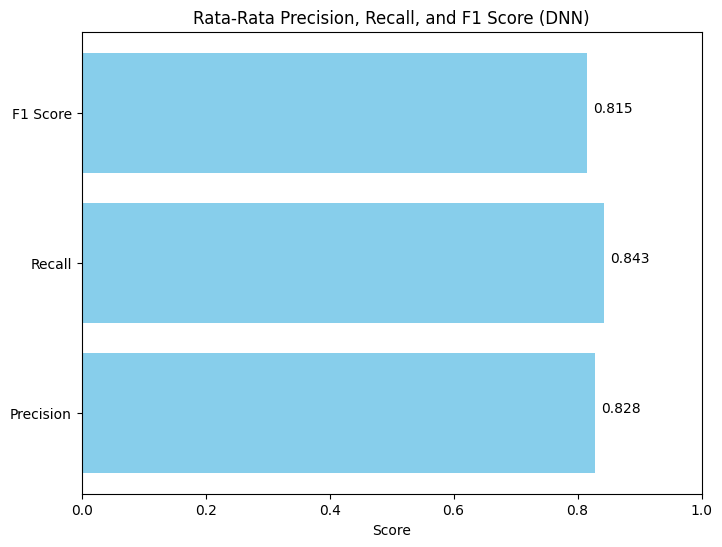

In [32]:
# Hitung jumlah rata-rata setiap metric
averagePrecisionDNN = round(sum(precisionDictDNN.values()) / len(precisionDictDNN), 3)
averageRecallDNN = round(sum(recallDictDNN.values()) / len(recallDictDNN), 3)
averageF1ScoreDNN = round(sum(f1ScoreDictDNN.values()) / len(f1ScoreDictDNN), 3)

# Ubah setiap metric dan labelnya ke dalam bentuk list
avgMetrics = ['Precision', 'Recall', 'F1 Score']
avgValues = [averagePrecisionDNN, averageRecallDNN, averageF1ScoreDNN]

# Plot hasil rata-rata metric
plt.figure(figsize=(8, 6))
plt.barh(avgMetrics, avgValues, color='blue')
plt.xlabel('Score')
plt.title('Rata-Rata Precision, Recall, and F1 Score (DNN)')
plt.xlim(0, 1)

# Tambah keterangan values dalam setiap bar
bars = plt.barh(avgMetrics, avgValues, color='skyblue')
for bar, value in zip(bars, avgValues):
    plt.text(value+0.01, bar.get_y() + bar.get_height() / 2, str(value))

plt.show()

Dapat dilihat dari nilai rata-rata setiap metrik evaluasi, Model sudah dapat memprediksi keseluruhan label dengan cukup baik, kesalahan hanya terjadi di beberapa label, namun kesalahan tersebut cukup buruk.

## Convolutional Neural Network

### Inisialisasi Model CNN

In [33]:
CNNmodel = tf.keras.models.Sequential([
    # Convolution Layer
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(cropSize,cropSize,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),


    # Ubah Array Gambar Hasil Konvolusi menjadi Array 1D
    tf.keras.layers.Flatten(),

    # Hidden Layer
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output Layer
    tf.keras.layers.Dense(units=26, activation='softmax')
])

### Compile Model CNN

In [34]:
CNNmodel.compile(
    optimizer='Adamax',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Keterangan Parameter Model CNN

In [35]:
CNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 64)          0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 5184)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1327360   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 26)                6682      
                                                      

### Train Model CNN

In [36]:
# Start Timestamp Pelatihan Model
startTime = time.time()

In [37]:
CNNhistory = CNNmodel.fit(
    xTrain, yTrain, # Data Latih dan Label
    batch_size = 16,
    epochs=8,
    validation_data=(xVal, yVal),
    verbose=1,
)

Epoch 1/8
22115/22115 [==============================] - 97s 4ms/step - loss: 0.1865 - accuracy: 0.9478 - val_loss: 0.0792 - val_accuracy: 0.9790
Epoch 2/8
22115/22115 [==============================] - 102s 5ms/step - loss: 0.0784 - accuracy: 0.9781 - val_loss: 0.0608 - val_accuracy: 0.9838
Epoch 3/8
22115/22115 [==============================] - 92s 4ms/step - loss: 0.0593 - accuracy: 0.9834 - val_loss: 0.0523 - val_accuracy: 0.9864
Epoch 4/8
22115/22115 [==============================] - 91s 4ms/step - loss: 0.0482 - accuracy: 0.9865 - val_loss: 0.0469 - val_accuracy: 0.9886
Epoch 5/8
22115/22115 [==============================] - 94s 4ms/step - loss: 0.0404 - accuracy: 0.9885 - val_loss: 0.0442 - val_accuracy: 0.9886
Epoch 6/8
22115/22115 [==============================] - 90s 4ms/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.0387 - val_accuracy: 0.9907
Epoch 7/8
22115/22115 [==============================] - 90s 4ms/step - loss: 0.0301 - accuracy: 0.9912 - val_loss: 0.0353 

In [38]:
# End Timestamp Pelatihan Model
endTime = time.time()
print("CNN Training Time")
print("--- %s seconds ---" % (endTime - startTime))

CNN Training Time
--- 804.9274470806122 seconds ---


### Evaluasi Model CNN

In [39]:
# Prediksi Data Validasi
valLoss, valAccuracy = CNNmodel.evaluate(xVal, yVal, verbose=False)
# Prediksi Data EMNIST
testLoss, testAccuracy = CNNmodel.evaluate(xTest, yTest, verbose=False)

print('Validation Data accuracy = ', valAccuracy*100)
print('EMNIST Testing accuracy = ', testAccuracy*100)

Validation Data accuracy =  99.28045868873596
EMNIST Testing accuracy =  87.84176111221313


#### Plot Akurasi per Epoch Model DNN

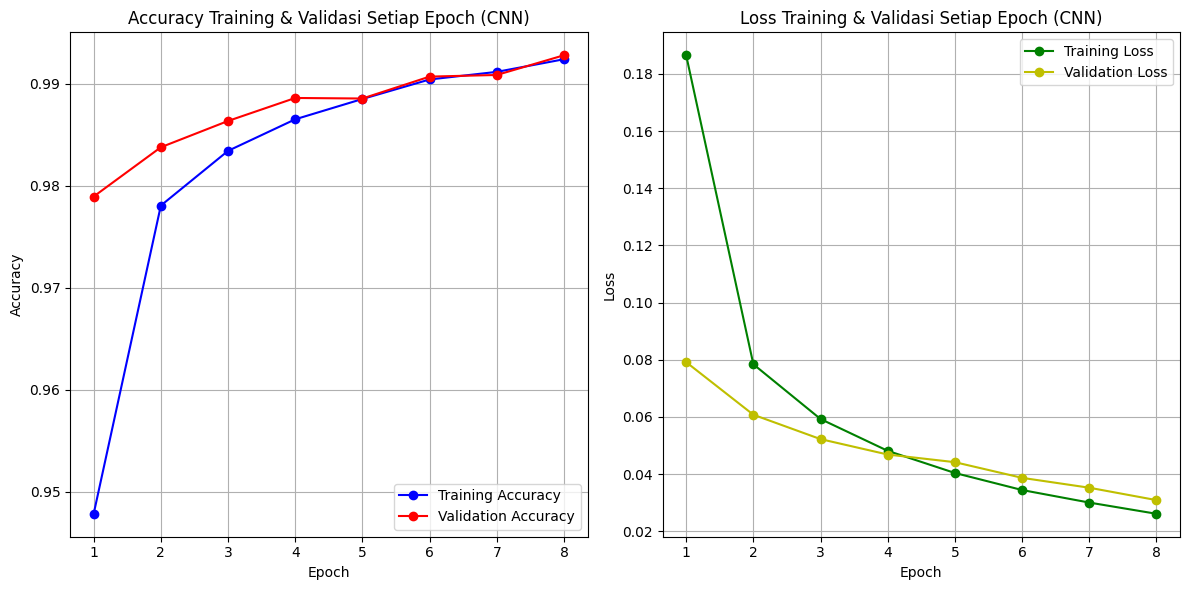

In [40]:
# Inisialisasi ukuran plot
plt.figure(figsize=(12, 6))

# Plot untuk akurasi
plt.subplot(1, 2, 1)
# Plot akurasi training
plt.plot(np.arange(1, len(CNNhistory.history['accuracy']) + 1), CNNhistory.history['accuracy'], marker='o', linestyle='-', color='b', label='Training Accuracy')
# Plot akurasi validasi
plt.plot(np.arange(1, len(CNNhistory.history['val_accuracy']) + 1), CNNhistory.history['val_accuracy'], marker='o', linestyle='-', color='r', label='Validation Accuracy')

# Keterangan Plot
plt.title('Accuracy Training & Validasi Setiap Epoch (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot untuk loss
plt.subplot(1, 2, 2)
# Plot loss training
plt.plot(np.arange(1, len(CNNhistory.history['loss']) + 1), CNNhistory.history['loss'], marker='o', linestyle='-', color='g', label='Training Loss')
# Plot loss validasi
plt.plot(np.arange(1, len(CNNhistory.history['val_loss']) + 1), CNNhistory.history['val_loss'], marker='o', linestyle='-', color='y', label='Validation Loss')

# Keterangan Plot
plt.title('Loss Training & Validasi Setiap Epoch (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Menyesuaikan Tata Letak
plt.tight_layout()

# Cetak plot
plt.show()

#### Confusion Matrix CNN

980/980 [==============================] - 2s 2ms/step
CNN Inference Time on EMNIST Dataset
--- 5.280179977416992 seconds ---


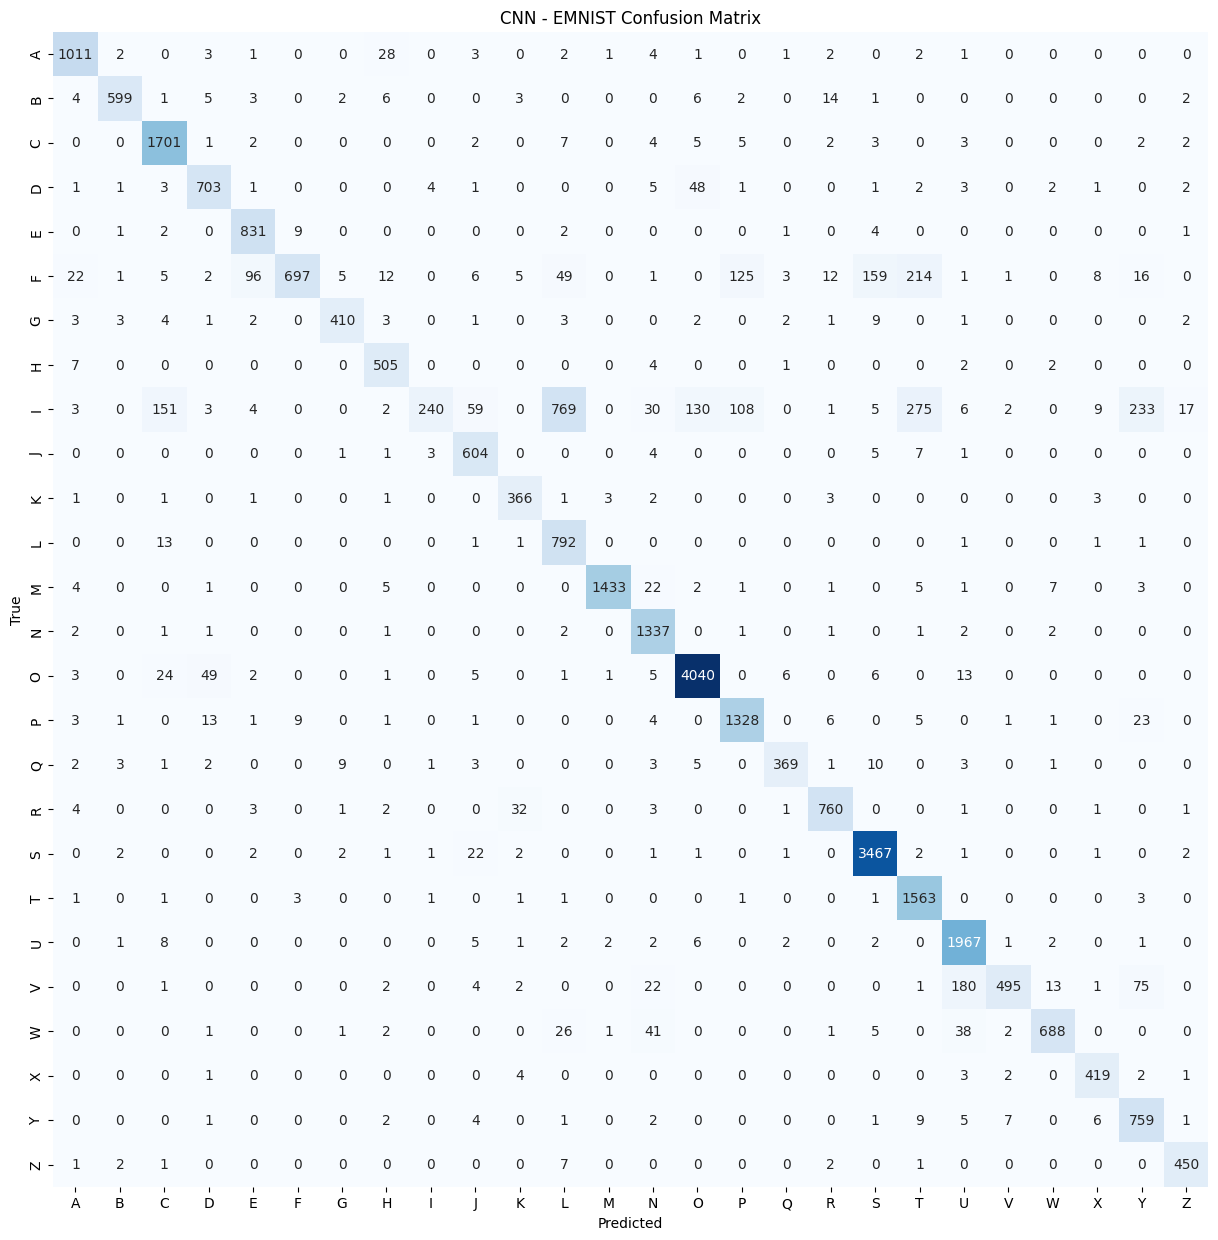

In [52]:
# Prediksi data EMNIST
startTime = time.time()
cnnEMNISTPred = np.argmax(CNNmodel.predict(xTest), axis=1)
endTime = time.time()
print("CNN Inference Time on EMNIST Dataset")
print("--- %s seconds ---" % (endTime - startTime))

# Buat confusion matrix berdasarkan hasil rediksi
cm = confusion_matrix(np.argmax(yTest, axis=1), cnnEMNISTPred)
# List label untuk confusion matrix
labelList = [chr(label+65) for label in range(26)]

# Plot confusion matrix dalam heatmap dengan letter labels
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labelList, yticklabels=labelList)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN - EMNIST Confusion Matrix')
plt.show()

Dapat dilihat dari confusion matrix model CNN diatas, model masih membuat banyak kesalahan pada label `I` dan `F`. Namun kesalahan tersebut menjadi terpusat, dimana model banyak memprediksi `I` sebagai `L` dan `F` sebagai `S`, `T`, dan `P`.

### Precision, Recall, F1 Score Model DNN

In [42]:
# Calculate precision, recall, and F1 score from the classification report
classificationReportCNN = classification_report(np.argmax(yTest, axis=1), cnnEMNISTPred, target_names=labelList)  # Replace labelList with your class labels

#### Cari Data Dengan Metrik Evaluasi Ter-rendah

In [43]:
# Inisialisasi Dictionary untuk menyimpan data evaluasi
precisionDictCNN = {}
recallDictCNN = {}
f1ScoreDictCNN = {}

# Split data metrik evaluasi ke dalam dictionary
for line in classificationReportCNN.split('\n')[2:-5] :
    label, precision, recall, f1Score = line.split()[:4]

    precisionDictCNN[label] = float(precision)
    recallDictCNN[label] = float(recall)
    f1ScoreDictCNN[label] = float(f1Score)

# Sort nilai precision secara ascending
sortedPrecisionCNN = sorted(precisionDictCNN.items(), key=lambda item: item[1])
# Sort nilai recall secara ascending
sortedRecallCNN = sorted(recallDictCNN.items(), key=lambda item: item[1])
# Sort nilai F1 score secara ascending
sortedF1ScoreCNN = sorted(f1ScoreDictCNN.items(), key=lambda item: item[1])

# Ambil 5 skor precision ter-rendah beserta label dan nilai recallnya
lowestPrecisionCNN = sortedPrecisionCNN[:5]
lowestPrecisionLabelsCNN = [item[0] for item in lowestPrecisionCNN]
recallValuesCNN = [recallDictCNN[label] for label in lowestPrecisionLabelsCNN]

# Ambil 5 skor recall ter-rendah beserta label dan nilai precisionnya
lowestRecallCNN = sortedRecallCNN[:5]
lowestRecallLabelsCNN = [item[0] for item in lowestRecallCNN]
precisionValuesCNN = [precisionDictCNN[label] for label in lowestRecallLabelsCNN]

# Ambil 5 skor F1 score ter-rendah beserta labelnya
lowestF1ScoreCNN = sortedF1ScoreCNN[:5]
lowestF1ScoreLabelsCNN = [item[0] for item in lowestF1ScoreCNN]

#### Plot Label Dengan Precision Score Ter-rendah

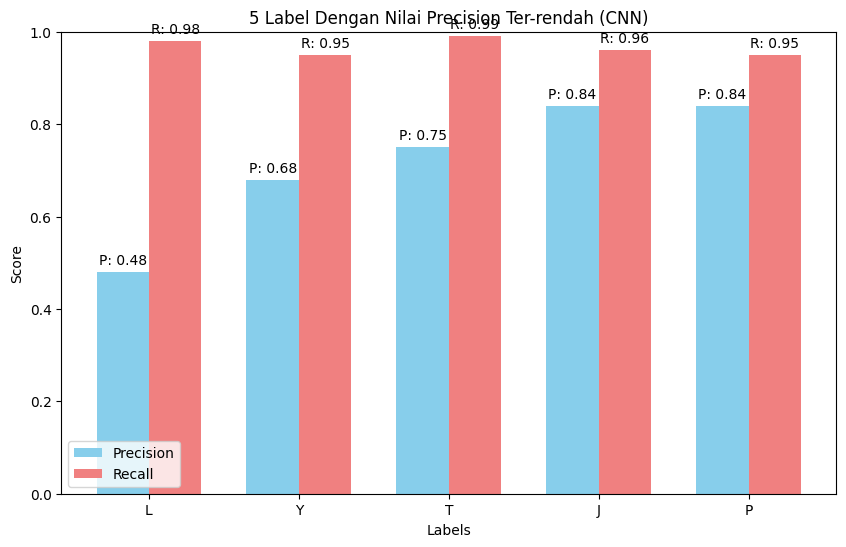

In [44]:
# Plot Jumlah, Lebar, dan Jarak antar label
x = np.arange(len(lowestPrecisionLabelsCNN))  # posisi x-axis
width = 0.35  # Lebar barchart

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot nilai precision
precisionBars = ax.bar(x - width/2, [item[1] for item in lowestPrecisionCNN], width, label='Precision', color='skyblue')
# Plot nilai recall
recallBars = ax.bar(x + width/2, recallValuesCNN, width, label='Recall', color='lightcoral')

# Loop untuk menambahkan nilai di atas setiap bar precision
for i, bar in enumerate(precisionBars):
    # Ambil nilai recall
    precisionValue = lowestPrecisionCNN[i][1]
    # Cetak nilai recall diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'P: {precisionValue:.2f}', ha='center', va='bottom')

# Loop untuk menambahkan nilai di atas setiap bar recall
for i, bar in enumerate(recallBars) :
    # Ambil nilai recall
    recallValue = recallValuesCNN[i]
    # Cetak nilai recall diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
        f'R: {recallValue:.2f}', ha='center', va='bottom')

# Tambah labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Score')
ax.set_title('5 Label Dengan Nilai Precision Ter-rendah (CNN)')
ax.set_xticks(x)
ax.set_xticklabels(lowestPrecisionLabelsCNN)
ax.set_ylim(0,1)
ax.legend(loc='lower left')

# Print barchart
plt.show()


Pada label `L`, nilai precision jauh lebih kecil pada model CNN dibandingkan DNN namun tetap memiliki recall yang sama. Ini mungkin disebabkan oleh layer kovolusi yang dapat menghasilkan respons yang lebih banyak terhadap berbagai fitur dan pola.

#### Plot Label Dengan Recall Ter-rendah

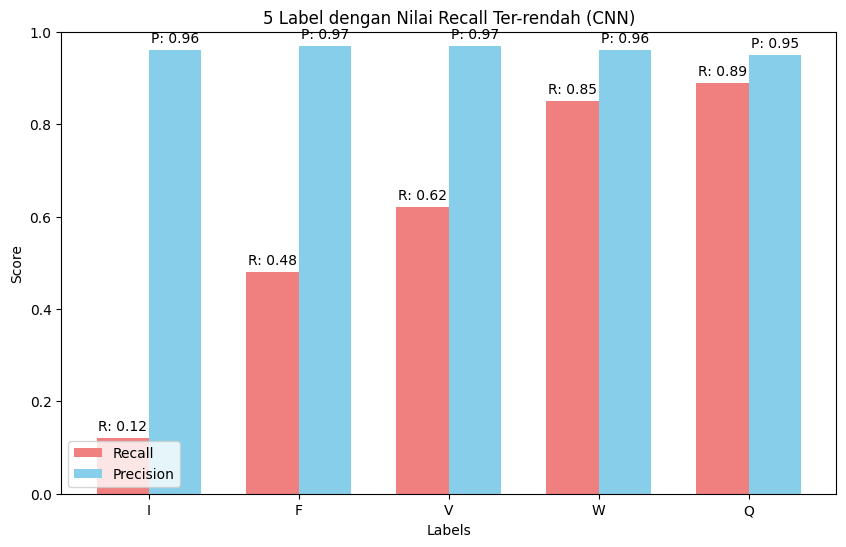

In [45]:
# Plot Jumlah, Lebar, dan Jarak antar label
x = np.arange(len(lowestRecallLabelsCNN))  # posisi x-axis
width = 0.35  # lebar barchart

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot nilai recall
recallBars = ax.bar(x - width/2, [item[1] for item in lowestRecallCNN], width, label='Recall', color='lightcoral')
# Plot nilai precision
precisionBars = ax.bar(x + width/2, precisionValuesCNN, width, label='Precision', color='skyblue')

# Loop untuk menambahkan nilai di atas setiap bar recall
for i, bar in enumerate(recallBars):
    # Ambil nilai recall
    recallValue = lowestRecallCNN[i][1]
    # Cetak nilai recall diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'R: {recallValue:.2f}', ha='center', va='bottom')

# Loop untuk menambahkan nilai di atas setiap bar precision
for i, bar in enumerate(precisionBars) :
    # Ambil nilai precision
    precisionValue = precisionValuesCNN[i]
    # Cetak nilai precision diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
        f'P: {precisionValue:.2f}', ha='center', va='bottom')

# Tambah labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Score')
ax.set_title('5 Label dengan Nilai Recall Ter-rendah (CNN)')
ax.set_xticks(x)
ax.set_xticklabels(lowestRecallLabelsCNN)
ax.set_ylim(0,1)
ax.legend(loc='lower left')

# Print barchart
plt.show()


5 Label dengan recall ter-rendah masih ditempati oleh label yang sama dengan DNN. Namun baik nilai recall dan precision memiliki nilai yang lebih tinggi dari hasil prediksi model DNN. Ini berarti model CNN dapat mengurangi kesalahan FN dibandingkan model DNN.

#### Plot label dengan F1 Score ter-rendah

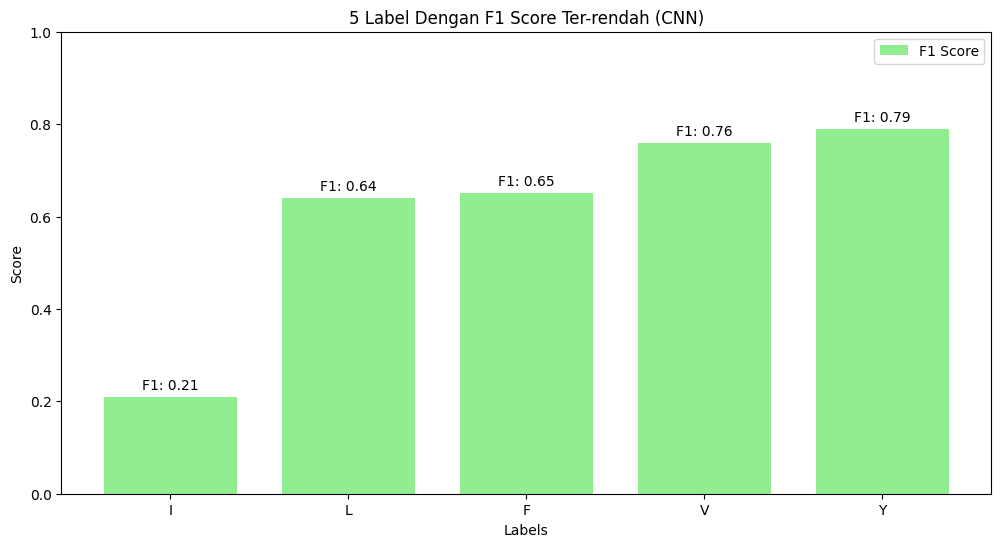

In [46]:
# Create a grouped bar chart for the 5 labels with the lowest F1 score and their precision and recall values
x = np.arange(len(lowestF1ScoreLabelsCNN))  # posisi x-axis
width = 0.75  # Lebar barchart

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(12, 6))
# Plot nilai F1 Score
f1ScoreBars = ax.bar(x, [item[1] for item in lowestF1ScoreCNN], width, label='F1 Score', color='lightgreen')

# Loop untuk menambahkan nilai di atas setiap bar f1Score
for i, bar in enumerate(f1ScoreBars):
    # Ambil nilai f1Score
    f1Value = lowestF1ScoreCNN[i][1]
    # Cetak nilai f1Score diatas barchart dalam plot
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'F1: {f1Value:.2f}', ha='center', va='bottom')

# Tambah labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Score')
ax.set_title('5 Label Dengan F1 Score Ter-rendah (CNN)')
ax.set_xticks(x)
ax.set_xticklabels(lowestF1ScoreLabelsCNN)
ax.set_ylim(0,1)
ax.legend()

# Cetak plot
plt.show()

Dari grafik 5 label dengan f1-score ter-rendah, label `I` masih memiliki nilai f1-score ter-rendah. Namun angka ini meningkat dari model DNN yang memiliki nilai `0.18` menjadi `0.26`.

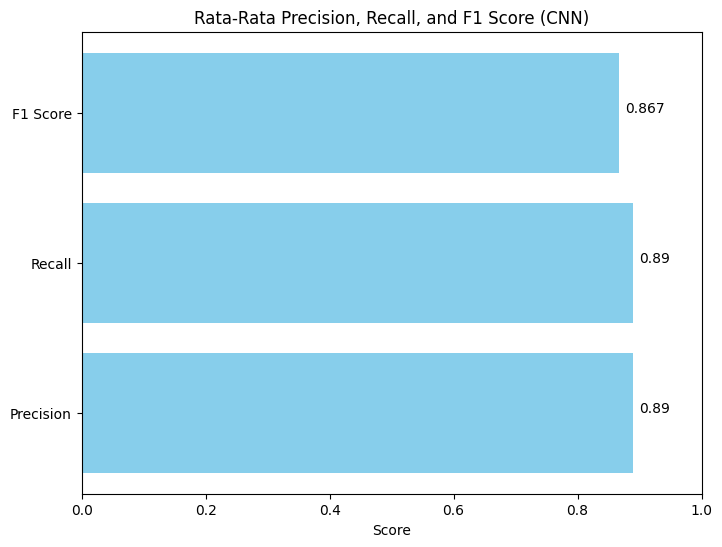

In [47]:
# Hitung jumlah rata-rata setiap metric
averagePrecisionCNN = round(sum(precisionDictCNN.values()) / len(precisionDictCNN), 3)
averageRecallCNN = round(sum(recallDictCNN.values()) / len(recallDictCNN), 3)
averageF1ScoreCNN = round(sum(f1ScoreDictCNN.values()) / len(f1ScoreDictCNN), 3)

# Ubah setiap metric dan labelnya ke dalam bentuk list
avgMetrics = ['Precision', 'Recall', 'F1 Score']
avgValues = [averagePrecisionCNN, averageRecallCNN, averageF1ScoreCNN]

# Plot hasil rata-rata metric
plt.figure(figsize=(8, 6))
plt.barh(avgMetrics, avgValues, color='blue')
plt.xlabel('Score')
plt.title('Rata-Rata Precision, Recall, and F1 Score (CNN)')
plt.xlim(0, 1)

# Tambah keterangan values dalam setiap bar
bars = plt.barh(avgMetrics, avgValues, color='skyblue')
for bar, value in zip(bars, avgValues):
    plt.text(value+0.01, bar.get_y() + bar.get_height() / 2, str(value))

plt.show()

Dapat dilihat, terdapat peningkatan pada setiap metrik evaluasi pada model CNN, tetapi peningkatan tersebut tidak signifikan. Ini menunjukkan bahwa penambahan layer konvolusi tidak terlalu efektif.

## Kesimpulan

- Model Deep Neural Network dengan hidden layer sebanyak 1 layer dengan jumlah preceptron 256 yang dilatih dengan menggunakan data dengan resolusi 20 x 20 meruppakan model Deep Neural Network terbaik. Model ini dilatih dengan resolusi yang lebih kecil dari data asli dan sudah memiliki akurasi 84.334% pada data EMNIST yang sudah melebihi parameter keberhasilan akurasi model. Model ini juga memiliki kecepatan inferensi 58000 gambar per detik yang sudah jauh melebihi parameter keberhasilan waktu inferensi.

- Model Convolutional Neural Network dengan layer konvolusi sebanyak 1 layer dengan jumlah kernel 64 yang dilatih dengan menggunakan data dengan resolusi 20 x 20 merupakan model Convolutional Neural Network terbaik. Model ini dilatih dengan resolusi yang lebih kecil dari data asli dan sudah memiliki akurasi 87.363% pada data EMNIST yang sudah melebihi parameter keberhasilan akurasi model. Model ini juga memiliki kecepatan inferensi 17000 gambar per detik yang sudah melebihi parameter keberhasilan waktu inferensi.

- Dapat disimpulkan bahwa model Deep Neural Network merupakan model terbaik. Ini dikarenakan waktu inferensi yang jauh lebih singkat dan akurasi yang tidak begitu jauh.

- Baik model DNN can CNN memiliki kesulitan mengklasifikasikan label 'I' dan 'F'. Label 'I' dan 'F' memiliki false positive yang sedikit, namun model melewatkan banyak huruf 'I' dan 'F' yang seharusnya diidentifikasi. Ini disimpulkan dari nilai precision pada label 'I' dan 'F' yang tinggi, sedangkan nilai recall sangat rendah.